###  Alzheimer's and Parkinson’s Disease Detection Using Convolutional Neural Networks: A Deep Learning Approach



#### Import Libraries

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
import os
import matplotlib.image as mpimg
import random
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator 

### For Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.layers import BatchNormalization  
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
 


### Load Data Set 

In [3]:
# Define the path and load the image links and labels
img_path = Path('G:/Avi Thesis/CodeFile/AD_PD_Final/3_cls/train')
image_links = list(img_path.glob(r'**/*.*'))
image_names = [x.parents[0].stem for x in image_links]
img_data = pd.DataFrame(list(zip(image_links, image_names)), columns=['Link', 'Name'])

print(img_data.head())  


                                                Link Name
0  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\train...   AD
1  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\train...   AD
2  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\train...   AD
3  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\train...   AD
4  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\train...   AD


In [4]:
# Define the path and load the image links and labels
img_path_test = Path('G:/Avi Thesis/CodeFile/AD_PD_Final/3_cls/test')
image_links = list(img_path_test.glob(r'**/*.*'))  # Use img_path_test instead of img_path
image_names = [x.parents[0].stem for x in image_links]
img_data_test = pd.DataFrame(list(zip(image_links, image_names)), columns=['Link', 'Name'])

print(img_data_test.head())  # Display the first few entries to confirm it's loaded correctly


                                                Link Name
0  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\test\...   AD
1  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\test\...   AD
2  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\test\...   AD
3  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\test\...   AD
4  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\test\...   AD


In [5]:
class_counts = img_data_test['Name'].value_counts()

# Printing the counts
print(class_counts)

Name
CONTROL    662
AD         639
PD          61
Name: count, dtype: int64


### Vizualize DataSet

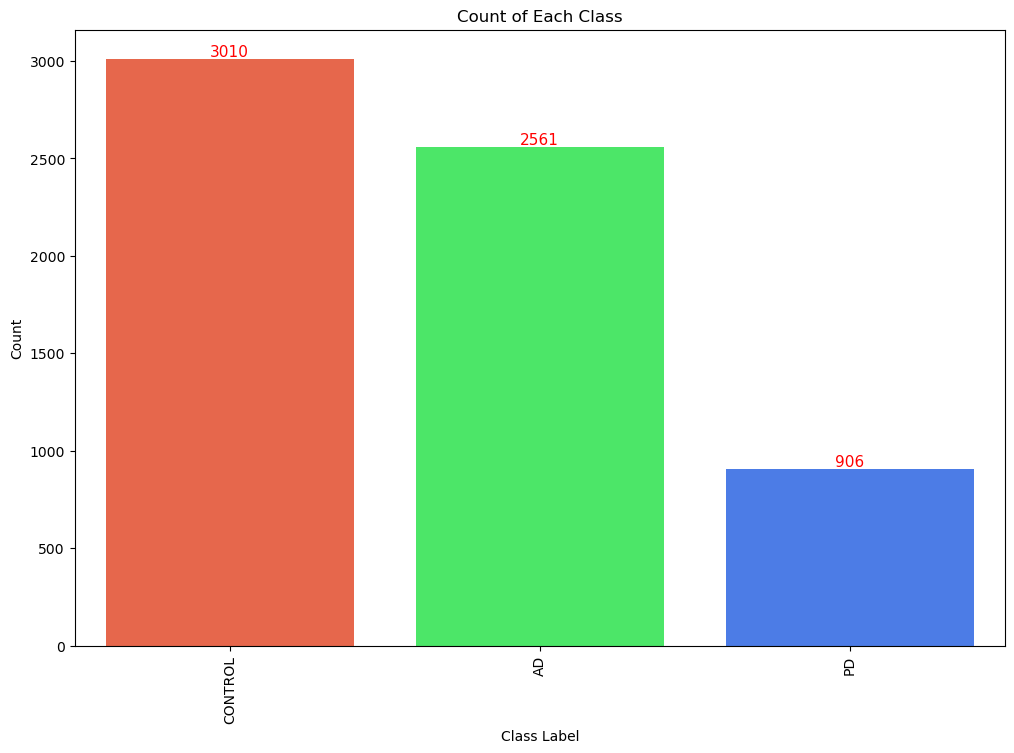

In [7]:
# Using Seaborn to plot the counts
plt.figure(figsize=(12, 8))
sns.countplot(data=img_data, x='Name', palette=clr_map, order=img_data['Name'].value_counts().index)

# Adding annotations with the count values
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='red', xytext=(0, 5),
                       textcoords='offset points')

plt.xticks(rotation=90)
plt.title('Count of Each Class')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()


### Data Preprocessing

## Testing Data

In [10]:
# Convert paths to strings
img_data_test['Link'] = img_data_test['Link'].astype(str)

# Define the image data generator for test data
test_val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_val_datagen.flow_from_dataframe(dataframe=img_data_test,
                                                      x_col='Link',
                                                      y_col='Name',  # Use 'Name' instead of 'Label'
                                                      target_size=(224, 224),
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      shuffle=False)


Found 1362 validated image filenames belonging to 3 classes.


In [8]:
print(img_data_test.columns)


Index(['Link', 'Name'], dtype='object')


#### Data Augmentation

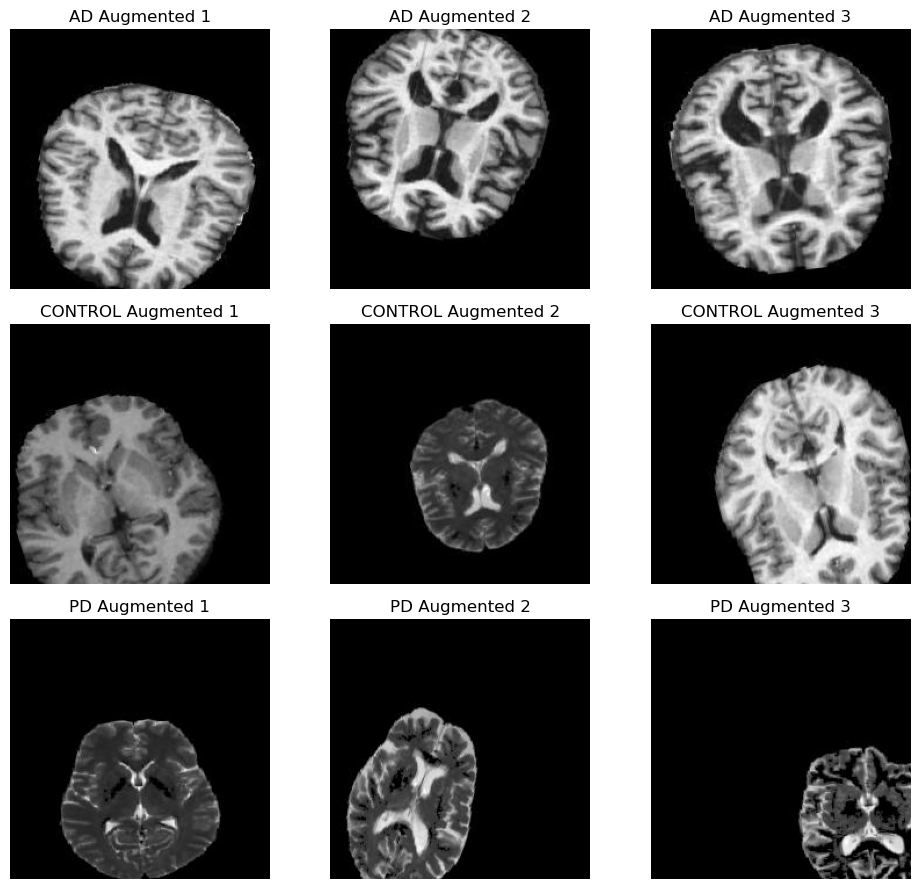

In [14]:
def plot_augmented_images(base_dir='augmented_data', num_samples=3):
    # Determine the number of classes
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    num_classes = len(class_dirs)

    plt.figure(figsize=(10, num_classes * 3))  # Set up figure size dynamically based on classes
    img_count = 1

    for class_name in class_dirs:
        class_dir = os.path.join(base_dir, class_name)
        image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                       if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        np.random.shuffle(image_files)  # Randomly shuffle the list of image files

        for i in range(min(num_samples, len(image_files))):
            img_path = image_files[i]
            img = load_img(img_path, target_size=(224, 224))  # Load and resize image for consistency
            img = np.array(img)  # Convert to array for plotting

            ax = plt.subplot(num_classes, num_samples, img_count)
            ax.imshow(img / 255.)  # Normalize and display the image
            ax.set_title(f"{class_name} Augmented {i+1}")
            ax.axis('off')
            img_count += 1

    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_augmented_images('augmented_data', num_samples=3)


In [ ]:
# Define augmentation configurations
augmentations = {
    'CONTROL': ImageDataGenerator(
        rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.15, zoom_range=0.15, horizontal_flip=True, vertical_flip=True,
        fill_mode='nearest'
    ),
    'AD': ImageDataGenerator(
        rotation_range=20, width_shift_range=0.15, height_shift_range=0.15,
        shear_range=0.1, zoom_range=0.1, horizontal_flip=True,
        fill_mode='nearest'
    ),
    'PD': ImageDataGenerator(
        rotation_range=60, width_shift_range=0.4, height_shift_range=0.4,
        shear_range=0.3, zoom_range=0.3, horizontal_flip=True, vertical_flip=True,
        fill_mode='nearest'
    )
}

def apply_balanced_augmentation(data, base_dir='augmented_data', target_counts=None):
    os.makedirs(base_dir, exist_ok=True)

    for class_name, generator in augmentations.items():
        class_data = data[data['Name'] == class_name]
        save_dir = os.path.join(base_dir, class_name)
        os.makedirs(save_dir, exist_ok=True)

        current_count = class_data.shape[0]
        target_count = target_counts[class_name]
        num_to_generate = target_count - current_count

        for img_path in class_data['Link']:
            img = load_img(img_path, target_size=(224, 224))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            gen_flow = generator.flow(img, batch_size=1, save_to_dir=save_dir, save_prefix='aug_', save_format='jpeg')
            
            for _ in range(min(num_to_generate, 5)):  # Limit augmentations per original image to prevent duplicates
                next(gen_flow)

# Example target counts to achieve a balanced dataset
target_counts = {
    'AD': max(3500, 3010),  # Using the highest current count as a target
    'CONTROL': max(3500, 3010),
    'PD': max(3500, 3010)
}

apply_balanced_augmentation(img_data, target_counts=target_counts)


In [12]:
def count_images_in_directory(directory):
    counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            num_images = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
            counts[class_dir] = num_images
    return counts


augmented_counts = count_images_in_directory('augmented_data')
print("Augmented class distribution:", augmented_counts)

Augmented class distribution: {'AD': 10000, 'CONTROL': 10000, 'PD': 10000}


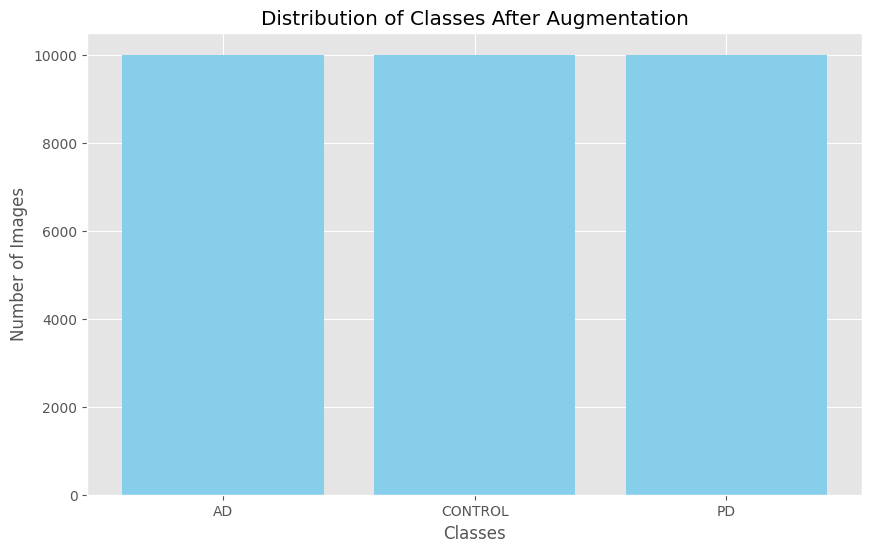

In [75]:
def plot_class_distribution(counts):
    """ Plots a bar chart of the class distribution given a dictionary of counts. """
    plt.figure(figsize=(10, 6))
    plt.bar(counts.keys(), counts.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Classes After Augmentation')
    plt.show()

plot_class_distribution(augmented_counts)

#### Spilt Data Set

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a common ImageDataGenerator configuration with a validation split
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of the data for validation
)

# Path to the directory where the augmented images are stored
base_dir = 'augmented_data'

# Set up training data generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(224, 224),  # All images will be resized to 224x224
    batch_size=32,
    class_mode='categorical',  # Because we have multiple classes
    subset='training',  # Specify this generator for training data
    shuffle=True  # Shuffle the data
)

# Set up validation data generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Specify this generator for validation data
    shuffle=True  # It's usually good practice to shuffle validation data as well
)


Found 24000 images belonging to 3 classes.
Found 6000 images belonging to 3 classes.


#### Build CNN Model

In [26]:
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
    return model

# Build and train the model
model_cnn = build_cnn_model()
history = model_cnn.fit(train_generator, epochs=5, validation_data=validation_generator)


Epoch 1/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 2154s 3s/step - accuracy: 0.7349 - auc: 0.8863 - loss: 1.1196 - precision: 0.7381 - recall: 0.7314 - val_accuracy: 0.7497 - val_auc: 0.9160 - val_loss: 0.5291 - val_precision: 0.7499 - val_recall: 0.7482
Epoch 2/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 2018s 3s/step - accuracy: 0.8453 - auc: 0.9582 - loss: 0.3781 - precision: 0.8465 - recall: 0.8418 - val_accuracy: 0.8719 - val_auc: 0.9705 - val_loss: 0.3133 - val_precision: 0.8724 - val_recall: 0.8713
Epoch 3/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 2214s 3s/step - accuracy: 0.8783 - auc: 0.9737 - loss: 0.2950 - precision: 0.8791 - recall: 0.8777 - val_accuracy: 0.8703 - val_auc: 0.9700 - val_loss: 0.3167 - val_precision: 0.8703 - val_recall: 0.8703
Epoch 4/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 2086s 3s/step - accuracy: 0.8999 - auc: 0.9812 - loss: 0.2480 - precision: 0.9005 - recall: 0.8992 - val_accuracy: 0.8740 - val_auc: 0.9690 - val_loss: 0.3315 - val_precision: 0.8741 - val_recall: 0.8740
Epoch 5/5
745/745 ━━━━━━━━━━

#### VGG16 Model

In [28]:
def build_vgg16_model(num_classes):
    # Load the VGG16 model, pre-trained on ImageNet, without the classifier layers on top
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the layers of the base model to avoid updating weights during training

    # Construct the new model by adding new layers on top of the base model
    model_vgg16 = Sequential([
        base_model,  # Base VGG16 model
        Flatten(),  # Flatten the output to a single dimension
        Dense(1024, activation='relu'),  # Dense layer with ReLU activation
        Dropout(0.5),  # Dropout for regularization
        Dense(num_classes, activation='softmax')  # Output layer with softmax activation for multi-class classification
    ])
    return model_vgg16


In [29]:
# Setup callbacks for model training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),  # Stop training when val_loss has stopped improving
    ModelCheckpoint('model_vgg16.keras', save_best_only=True)  # Save the best version of the model
]

In [30]:
optimizer = Adam(learning_rate=0.001)

num_classes = 3
model_vgg16 = build_vgg16_model(num_classes)
model_vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

In [31]:
history_vgg16 = model_vgg16.fit(train_generator,
                    epochs = 3,
                    validation_data = validation_generator,
                    verbose = 1,
                   callbacks=callbacks)

Epoch 1/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 3929s 5s/step - accuracy: 0.7825 - auc: 0.9090 - loss: 0.7810 - precision: 0.7844 - recall: 0.7795 - val_accuracy: 0.8673 - val_auc: 0.9709 - val_loss: 0.3149 - val_precision: 0.8676 - val_recall: 0.8673
Epoch 2/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 4050s 5s/step - accuracy: 0.8537 - auc: 0.9638 - loss: 0.3449 - precision: 0.8568 - recall: 0.8498 - val_accuracy: 0.8821 - val_auc: 0.9777 - val_loss: 0.2705 - val_precision: 0.8823 - val_recall: 0.8820
Epoch 3/3
309/750 ━━━━━━━━━━━━━━━━━━━━ 26:16 4s/step - accuracy: 0.8623 - auc: 0.9675 - loss: 0.3271 - precision: 0.8652 - recall: 0.8590

#### Build Xception

In [31]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
def build_xception_model(num_classes):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    model_xceptionmodel = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model_xceptionmodel


In [36]:
num_classes = 3 
model_Xception = build_xception_model(num_classes)


In [37]:
# Compile the model
model_Xception.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)


In [38]:
# Fit the model
history = model_Xception.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3,  # Number of epochs to train
     
)

Epoch 1/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 2267s 3s/step - accuracy: 0.7702 - auc: 0.9205 - loss: 0.5026 - precision: 0.7717 - recall: 0.7635 - val_accuracy: 0.8535 - val_auc: 0.9645 - val_loss: 0.3388 - val_precision: 0.8537 - val_recall: 0.8533
Epoch 2/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 2218s 3s/step - accuracy: 0.8404 - auc: 0.9585 - loss: 0.3674 - precision: 0.8406 - recall: 0.8392 - val_accuracy: 0.8545 - val_auc: 0.9670 - val_loss: 0.3274 - val_precision: 0.8546 - val_recall: 0.8545
Epoch 3/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 2657s 4s/step - accuracy: 0.8560 - auc: 0.9660 - loss: 0.3325 - precision: 0.8565 - recall: 0.8554 - val_accuracy: 0.8681 - val_auc: 0.9700 - val_loss: 0.3127 - val_precision: 0.8682 - val_recall: 0.8678


#### Build DenseNet121

In [16]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

def build_densenet121_model(num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model to reuse the pre-trained features

    model_dense121 = Sequential([
        base_model,
        Dense(1024, activation='relu'),  # Dense layer for deeper feature learning
        Dropout(0.5),  # Dropout to prevent overfitting
             GlobalAveragePooling2D(),  # Use global average pooling to reduce the spatial dimensions
   Dense(num_classes, activation='softmax')  # Output layer for classification
    ])
    return model_dense121


In [17]:
# Example configuration
num_classes = 3

# Building the model
model_dense121 = build_densenet121_model(num_classes)

# Compile the model
model_dense121.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)


In [19]:
# Fit the model
history_dense121 = model_dense121.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
    
)


Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2078s 3s/step - accuracy: 0.7778 - auc: 0.9182 - loss: 0.5405 - precision: 0.7794 - recall: 0.7742 - val_accuracy: 0.8638 - val_auc: 0.9693 - val_loss: 0.3188 - val_precision: 0.8639 - val_recall: 0.8636
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2730s 4s/step - accuracy: 0.8478 - auc: 0.9628 - loss: 0.3485 - precision: 0.8480 - recall: 0.8468 - val_accuracy: 0.8663 - val_auc: 0.9688 - val_loss: 0.3200 - val_precision: 0.8662 - val_recall: 0.8658
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 1969s 3s/step - accuracy: 0.8601 - auc: 0.9676 - loss: 0.3244 - precision: 0.8603 - recall: 0.8596 - val_accuracy: 0.8820 - val_auc: 0.9762 - val_loss: 0.2821 - val_precision: 0.8820 - val_recall: 0.8818
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 1950s 3s/step - accuracy: 0.8698 - auc: 0.9720 - loss: 0.3024 - precision: 0.8699 - recall: 0.8695 - val_accuracy: 0.8868 - val_auc: 0.9773 - val_loss: 0.2728 - val_precision: 0.8871 - val_recall: 0.8868
Epoch 5/5
750/750 ━━━━━━━━━━

####  Build InceptioonV3 Model

In [20]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

def build_inceptionv3_model(num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model to reuse the pre-trained features

    model_inceptionv3 = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Use global average pooling to reduce the spatial dimensions
        Dense(1024, activation='relu'),  # Dense layer for deeper feature learning
        Dropout(0.5),  # Dropout to prevent overfitting
        Dense(num_classes, activation='softmax')  # Output layer for classification
    ])
    return model_inceptionv3

In [21]:
# Example configuration
num_classes = 3

# Building the model
model_inceptionv3 = build_inceptionv3_model(num_classes)

# Compile the model
model_inceptionv3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)


In [22]:
# Fit the model
model_inceptionv3 = model_inceptionv3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
    
)


Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 1108s 1s/step - accuracy: 0.7731 - auc: 0.9132 - loss: 0.6189 - precision: 0.7760 - recall: 0.7699 - val_accuracy: 0.8326 - val_auc: 0.9557 - val_loss: 0.3819 - val_precision: 0.8338 - val_recall: 0.8313
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 1176s 2s/step - accuracy: 0.8331 - auc: 0.9533 - loss: 0.3906 - precision: 0.8339 - recall: 0.8319 - val_accuracy: 0.8583 - val_auc: 0.9670 - val_loss: 0.3281 - val_precision: 0.8584 - val_recall: 0.8580
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 1422s 2s/step - accuracy: 0.8398 - auc: 0.9593 - loss: 0.3649 - precision: 0.8407 - recall: 0.8386 - val_accuracy: 0.8670 - val_auc: 0.9703 - val_loss: 0.3105 - val_precision: 0.8671 - val_recall: 0.8670
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 1151s 2s/step - accuracy: 0.8476 - auc: 0.9622 - loss: 0.3508 - precision: 0.8484 - recall: 0.8468 - val_accuracy: 0.8690 - val_auc: 0.9705 - val_loss: 0.3097 - val_precision: 0.8699 - val_recall: 0.8686
Epoch 5/5
750/750 ━━━━━━━━━━